In [109]:
# Importing libraries
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import glob
import torch.nn.functional as F
import torch.nn as nn
#from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
import random
import itertools
from sklearn.metrics import confusion_matrix
from skimage.segmentation import mark_boundaries


In [110]:
#  Setting up the device that will be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cpu


In [111]:
# Chemin vers le dossier contenant les fichiers 2D créés
chaos_dir = 'CHAOS-MRT2-2D-NORMALIZED'

# Récupérer tous les fichiers source et masque 2D
all_src_files = sorted(glob.glob(os.path.join(chaos_dir, '*-src-z*.nii.gz')))
all_mask_files = sorted(glob.glob(os.path.join(chaos_dir, '*-mask-z*.nii.gz')))

# Vérification de la correspondance des fichiers source et masque
assert len(all_src_files) == len(all_mask_files), "Le nombre de fichiers source et masque ne correspond pas!"

# Taille cible (à adapter selon vos besoins)
target_shape = (256, 256)  # Pour les images 2D

# Définition du Dataset personnalisé
class LazyNii2DDataset(Dataset):
    def __init__(self, src_files, mask_files, target_shape):
        self.src_files = src_files
        self.mask_files = mask_files
        self.target_shape = target_shape

    def __len__(self):
        return len(self.src_files)

    def __getitem__(self, idx):
        # Charger le fichier source et le fichier masque
        src_tensor = self.load_and_resize(self.src_files[idx])
        mask_tensor = self.load_and_resize(self.mask_files[idx])

        # Ajouter la dimension du canal
        src_tensor = src_tensor.unsqueeze(0)  # (1, H, W) pour les données
        mask_tensor = mask_tensor.unsqueeze(0)  # (1, H, W) pour les masques, si besoin

        return src_tensor, mask_tensor

    def load_and_resize(self, file_path):
        nii = nib.load(file_path)
        img_data = nii.get_fdata()
        tensor_data = torch.tensor(img_data, dtype=torch.float32)

        # Ajouter la dimension channel et redimensionner à la taille cible
        tensor_data = tensor_data.unsqueeze(0)  # Ajouter la dimension channel
        resized_tensor = F.interpolate(tensor_data.unsqueeze(0), size=self.target_shape, mode='bilinear', align_corners=False)
        return resized_tensor.squeeze()  # Supprimer la dimension batch

from collections import defaultdict
import random

# Regrouper les fichiers par identifiant XX
grouped_files = defaultdict(lambda: {'src': [], 'mask': []})

for src_file, mask_file in zip(all_src_files, all_mask_files):
    identifier = src_file.split('/')[-1].split('-')[0]  # Extraire XX de 'XX-T2SPIR-Y-z(numéro).nii.gz'
    grouped_files[identifier]['src'].append(src_file)
    grouped_files[identifier]['mask'].append(mask_file)

# Convertir le dictionnaire en listes pour faciliter le split
group_keys = list(grouped_files.keys())
random.seed(42)  # Pour la reproductibilité
random.shuffle(group_keys)

# Diviser les groupes en train, val et test
train_split = int(0.8 * len(group_keys))  # 80% pour l'entraînement
val_split = int(0.1 * len(group_keys))  # 10% pour la validation
test_split = len(group_keys) - train_split - val_split  # 10% restant pour le test

train_keys = group_keys[:train_split]
val_keys = group_keys[train_split:train_split + val_split]
test_keys = group_keys[train_split + val_split:]

# Fonction pour rassembler les fichiers selon les clés
def get_files_from_keys(keys, grouped_files):
    src_files = []
    mask_files = []
    for key in keys:
        src_files.extend(grouped_files[key]['src'])
        mask_files.extend(grouped_files[key]['mask'])
    return src_files, mask_files

# Obtenir les fichiers pour chaque ensemble
train_src, train_mask = get_files_from_keys(train_keys, grouped_files)
val_src, val_mask = get_files_from_keys(val_keys, grouped_files)
test_src, test_mask = get_files_from_keys(test_keys, grouped_files)

# Créer les datasets
train_dataset = LazyNii2DDataset(train_src, train_mask, target_shape)
val_dataset = LazyNii2DDataset(val_src, val_mask, target_shape)
test_dataset = LazyNii2DDataset(test_src, test_mask, target_shape)

# Créer les DataLoaders
batch_size = 8  # Taille de batch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Vérifier la distribution des données
print(f"Train set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")
print(f"Test set: {len(test_dataset)} images")


Train set: 473 images
Validation set: 30 images
Test set: 84 images


In [55]:
# Fonction pour afficher les noms des fichiers dans un DataLoader
def show_filenames_in_loader(loader, loader_name="Loader"):
    print(f"Fichiers dans {loader_name}:")
    dataset = loader.dataset
    for i in range(len(dataset)):
        src_file = dataset.src_files[i]
        mask_file = dataset.mask_files[i]
        print(f"Source: {src_file}, Masque: {mask_file}")

# Afficher les noms des fichiers pour chaque loader
#show_filenames_in_loader(train_loader, "Train Loader")
show_filenames_in_loader(val_loader, "Validation Loader")
#show_filenames_in_loader(test_loader, "Test Loader")


Fichiers dans Validation Loader:
Source: CHAOS-MRT2-2D-NORMALIZED/19-T2SPIR-src-z0.nii.gz, Masque: CHAOS-MRT2-2D-NORMALIZED/19-T2SPIR-mask-z0.nii.gz
Source: CHAOS-MRT2-2D-NORMALIZED/19-T2SPIR-src-z1.nii.gz, Masque: CHAOS-MRT2-2D-NORMALIZED/19-T2SPIR-mask-z1.nii.gz
Source: CHAOS-MRT2-2D-NORMALIZED/19-T2SPIR-src-z10.nii.gz, Masque: CHAOS-MRT2-2D-NORMALIZED/19-T2SPIR-mask-z10.nii.gz
Source: CHAOS-MRT2-2D-NORMALIZED/19-T2SPIR-src-z11.nii.gz, Masque: CHAOS-MRT2-2D-NORMALIZED/19-T2SPIR-mask-z11.nii.gz
Source: CHAOS-MRT2-2D-NORMALIZED/19-T2SPIR-src-z12.nii.gz, Masque: CHAOS-MRT2-2D-NORMALIZED/19-T2SPIR-mask-z12.nii.gz
Source: CHAOS-MRT2-2D-NORMALIZED/19-T2SPIR-src-z13.nii.gz, Masque: CHAOS-MRT2-2D-NORMALIZED/19-T2SPIR-mask-z13.nii.gz
Source: CHAOS-MRT2-2D-NORMALIZED/19-T2SPIR-src-z14.nii.gz, Masque: CHAOS-MRT2-2D-NORMALIZED/19-T2SPIR-mask-z14.nii.gz
Source: CHAOS-MRT2-2D-NORMALIZED/19-T2SPIR-src-z15.nii.gz, Masque: CHAOS-MRT2-2D-NORMALIZED/19-T2SPIR-mask-z15.nii.gz
Source: CHAOS-MRT2-2D-NORMA

In [122]:
class AttentionBlock2D(nn.Module):
    def __init__(self, F_g, F_l, n_coefficients):
        super(AttentionBlock2D, self).__init__()
        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, skip_connection, return_attention=False):
        g1 = self.W_gate(gate)
        x1 = self.W_x(skip_connection)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        attentionMap=None
        if return_attention:
            attentionMap= psi  # Renvoie la carte d'attention
        
        out = skip_connection * psi
        return out,attentionMap


class UNetAug2D(nn.Module):
    def __init__(self, in_channels=1, out_channels=5, n_coefficients=3):
        super(UNetAug2D, self).__init__()

        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Contracting path
        self.enc1 = self.contract_block(in_channels, 64)
        self.enc2 = self.contract_block(64, 128)
        self.enc3 = self.contract_block(128, 256)
        self.enc4 = self.contract_block(256, 512)
        self.enc5 = self.contract_block(512, 1024)

        # Expanding path
        self.dec5 = self.expand_block(1024, 512)
        self.att5 = AttentionBlock2D(F_g=512, F_l=512, n_coefficients=256)
        self.conv5 = self.contract_block(1024, 512)

        self.dec4 = self.expand_block(512, 256)
        self.att4 = AttentionBlock2D(F_g=256, F_l=256, n_coefficients=128)
        self.conv4 = self.contract_block(512, 256)

        self.dec3 = self.expand_block(256, 128)
        self.att3 = AttentionBlock2D(F_g=128, F_l=128, n_coefficients=64)
        self.conv3 = self.contract_block(256, 128)

        self.dec2 = self.expand_block(128, 64)
        self.att2 = AttentionBlock2D(F_g=64, F_l=64, n_coefficients=32)
        self.conv2 = self.contract_block(128, 64)

        # Output layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1, stride=1, padding=0)

    def contract_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def expand_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    
    def forward(self, x, return_attention=False):
        attention_maps = []  # Liste pour stocker les cartes d'attention
        
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.MaxPool(enc1))
        enc3 = self.enc3(self.MaxPool(enc2))
        enc4 = self.enc4(self.MaxPool(enc3))
        enc5 = self.enc5(self.MaxPool(enc4))

        dec5 = self.dec5(enc5)
        att4,bis = self.att5(gate=dec5, skip_connection=enc4, return_attention=return_attention)
        if return_attention: 
            attention_maps.append(bis)
        dec5 = torch.cat((att4, dec5), dim=1)
        dec5 = self.conv5(dec5)

        dec4 = self.dec4(dec5)
        att3,bis2 = self.att4(gate=dec4, skip_connection=enc3, return_attention=return_attention)
        if return_attention: 
            attention_maps.append(bis2)
        dec4 = torch.cat((att3, dec4), dim=1)
        dec4 = self.conv4(dec4)

        dec3 = self.dec3(dec4)
        att2,bis3 = self.att3(gate=dec3, skip_connection=enc2, return_attention=return_attention)
        if return_attention: 
            attention_maps.append(bis3)
        dec3 = torch.cat((att2, dec3), dim=1)
        dec3 = self.conv3(dec3)

        dec2 = self.dec2(dec3)
        att1,bis4 = self.att2(gate=dec2, skip_connection=enc1, return_attention=return_attention)
        if return_attention: 
            attention_maps.append(bis4)
        dec2 = torch.cat((att1, dec2), dim=1)
        dec2 = self.conv2(dec2)

        if return_attention:
            return self.final_conv(dec2), attention_maps  # Renvoie la sortie + cartes d'attention
        
        return self.final_conv(dec2)


# Instantiate the model
model = UNetAug2D()
model.to(device)
#summary(model, input_size=(1, 1, 256, 256)) # Example input size for 2D




UNetAug2D(
  (MaxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1

In [113]:
class UNet2d(nn.Module):
    def __init__(self, in_channels=1, out_channels=5):
        super(UNet2d, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)  # Optionnel, à tester selon les besoins

        # Contracting path
        self.enc1 = self.contract_block(in_channels, 64)
        self.enc2 = self.contract_block(64, 128)
        self.enc3 = self.contract_block(128, 256)
        self.enc4 = self.contract_block(256, 512)

        # Bottleneck
        self.bottleneck = self.contract_block(512, 1024)

        # Expanding path
        self.dec4 = self.expand_block(1024 + 512, 512)
        self.dec3 = self.expand_block(512 + 256, 256)
        self.dec2 = self.expand_block(256 + 128, 128)
        self.dec1 = self.expand_block(128 + 64, 64)

        # Output layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def contract_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def expand_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def up_concat(self, x1, x2):
        # Redimensionner x1 pour qu'il corresponde à la taille de x2
        x1 = F.interpolate(x1, size=x2.size()[2:], mode='bilinear', align_corners=True)
        return torch.cat([x1, x2], dim=1)

    def forward(self, x):
        # Encode
        enc1 = self.enc1(x)
        enc1_pool = self.maxpool(enc1)

        enc2 = self.enc2(enc1_pool)
        enc2_pool = self.maxpool(enc2)

        enc3 = self.enc3(enc2_pool)
        enc3_pool = self.maxpool(enc3)

        enc4 = self.enc4(enc3_pool)
        enc4_pool = self.maxpool(enc4)

        # Bottleneck
        bottleneck = self.bottleneck(enc4_pool)

        # Decode
        dec4 = self.up_concat(bottleneck, enc4)
        dec4 = self.dec4(dec4)

        dec3 = self.up_concat(dec4, enc3)
        dec3 = self.dec3(dec3)

        dec2 = self.up_concat(dec3, enc2)
        dec2 = self.dec2(dec2)

        dec1 = self.up_concat(dec2, enc1)
        dec1 = self.dec1(dec1)

        # Redimensionner la sortie finale à 256x256
        dec1 = F.interpolate(dec1, size=(256, 256), mode='bilinear', align_corners=True)

        return self.final_conv(dec1)

# Créer l'instance du modèle
model2 = UNet2d()
model2.to(device)

UNet2d(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel

In [114]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Critère : combinaison de Dice Loss et Cross Entropy Loss
def dice_loss(pred, target, smooth=1.0):
    """
    Calcul de la Dice Loss.
    Args:
        pred (Tensor): Prédictions du modèle (avant ou après activation, par ex. Sigmoid).
        target (Tensor): Masques cibles (binaire ou multi-classes).
        smooth (float): Valeur pour éviter une division par zéro.
    Returns:
        float: Valeur de la Dice Loss.
    """
    pred = torch.sigmoid(pred)  # Activation sigmoid pour les sorties brutes
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))

def combined_loss(pred, target):
    """
    Combinaison de la Cross Entropy Loss et de la Dice Loss.
    Args:
        pred (Tensor): Prédictions du modèle (logits).
        target (Tensor): Masques cibles (indices de classes pour Cross Entropy Loss).
    Returns:
        float: Perte combinée.
    """
    # Cross Entropy Loss
    ce_loss = F.cross_entropy(pred, target)
    # Dice Loss
    dice = dice_loss(pred, target)
    # Perte combinée
    return ce_loss + dice

# Poids égaux à l'inverse des fréquences des classes
class_weights = torch.tensor([1.04, 30.3, 263.1, 158.7, 270.3]).to(device)  # Déplace les poids sur le même device que le modèle

# Définition de la perte pondérée
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimiseur Adam avec un learning rate plus bas
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)


In [12]:
n_epochs = 60  # nombre d'époques d'entraînement

# Fonction d'entraînement modifiée
def training(model, criterion, optimizer, train_loader, val_loader,device):
    numberSamples = len(train_loader.dataset)
    train_losses, valid_losses = [], []
    valid_loss_min = 0.087476513783137
    i = 1

    for epoch in range(n_epochs):
        train_loss, valid_loss = 0, 0

        # Entraînement
        model.train()
        for data, label in train_loader:
            data = data.to(device)  # Ajouter la dimension des canaux
            label = label.squeeze(1).to(device).long()

            optimizer.zero_grad()
            output = model(data)

            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
            print(epoch,i,":",train_loss)
            i += 1


        # Validation
        model.eval()
        for data, label in val_loader:
            data = data.to(device)  # Ajouter la dimension des canaux
            label = label.squeeze(1).to(device).long()

            with torch.no_grad():
                output = model(data)
            loss = criterion(output, label)
            valid_loss += loss.item() * data.size(0)

        # Calcul des pertes moyennes
        train_loss /= len(train_loader.dataset)
        valid_loss /= len(val_loader.dataset)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')

        # Sauvegarder le modèle si la perte de validation a diminué
        if valid_loss <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...')
            torch.save(model.state_dict(), 'telecharger/modelUnetAugmented.pt')
            valid_loss_min = valid_loss

    return train_losses, valid_losses


# Exécuter l'entraînement


In [34]:
train_losses, valid_losses = training(model, criterion, optimizer, train_loader, val_loader,device)

0 1 : 0.4149935841560364
0 2 : 0.603781670331955
0 3 : 0.8787007927894592
0 4 : 1.1237432062625885
0 5 : 1.343023642897606
0 6 : 1.571407601237297
0 7 : 1.9517122954130173
0 8 : 2.3966537564992905
0 9 : 2.695738211274147
0 10 : 3.012737914919853
0 11 : 3.31074883043766
0 12 : 3.480808839201927
0 13 : 3.7421166747808456
0 14 : 4.146534934639931
0 15 : 4.548589184880257
0 16 : 4.846978977322578
0 17 : 5.2425423711538315
0 18 : 5.814501449465752
0 19 : 6.32811276614666
0 20 : 6.493105441331863
0 21 : 6.739524021744728
0 22 : 6.907679095864296
0 23 : 7.308879688382149
0 24 : 7.4809500426054
0 25 : 7.6556607484817505
0 26 : 7.834778994321823
0 27 : 8.115736305713654
0 28 : 8.475991547107697
0 29 : 8.632588967680931
0 30 : 8.922917440533638
0 31 : 9.209156587719917
0 32 : 9.519198432564735
0 33 : 9.663318529725075
0 34 : 10.022459492087364
0 35 : 10.16078594326973
0 36 : 10.305941447615623
0 37 : 10.474560245871544
0 38 : 10.7809769064188
0 39 : 10.969899877905846
0 40 : 11.113194808363914
0

KeyboardInterrupt: 

In [18]:
print(train_losses)
print(valid_losses)
#Sauvegarde des poids du modèle :
# Chemin où tu veux sauvegarder les poids (par exemple, dans un fichier .pth)
checkpoint_weights_path = 'telecharger/weightsepoque150.pth'

# Sauvegarder les poids du modèle
torch.save(model.state_dict(), checkpoint_weights_path)
print(f"Model weights saved in  {checkpoint_weights_path}")

#Sauvegarde de tous le modèle :
# Sauvegarder tout le modèle (pas uniquement les poids)
checkpoint_model_path = 'telecharger/fullmodelepoque150.pth'
torch.save(model, checkpoint_model_path)
print(f"Model saved in {checkpoint_model_path}")

# Charger tout le modèle
#model = torch.load('full_model.pth')
#model.eval()  # Ne pas oublier de passer en mode évaluation pour les prédictions


NameError: name 'train_losses' is not defined

0.087476513783137
150


Text(0, 0.5, 'loss value')

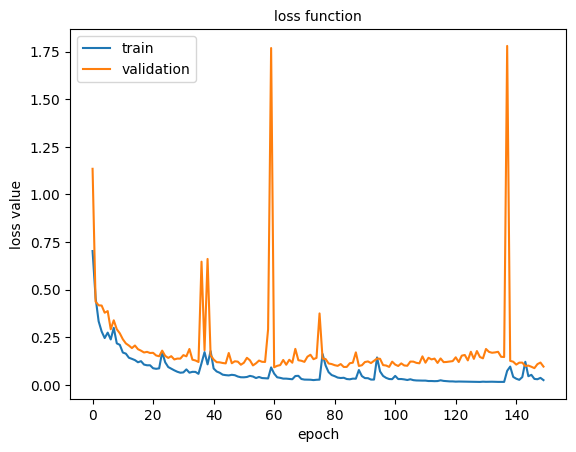

In [19]:
a=[0.7028915849346943, 0.45681961873117005, 0.3338085141418852, 0.28016823769623833, 0.24562172695647838, 0.2742187578632766, 0.2383417690027088, 0.2994346559425741, 0.21765840828544747, 0.20992018361172263, 0.16952919203937683, 0.16370589936636468, 0.14216627990216585, 0.13627500268167975, 0.12965940282410346, 0.1184351209228185, 0.1241208338838299, 0.10619949059556957, 0.10247751881405869, 0.10259643330949557, 0.08695731173421062, 0.08396969367031315, 0.08633872145200129, 0.17195661813335741, 0.11818081732784215, 0.09330302634400495, 0.08472647506893312, 0.07601925031327295, 0.06854336288212218, 0.06347658978204143, 0.0650576517521453, 0.08084100968426933, 0.06379786952857487, 0.06813199033696858, 0.06772924157895195, 0.05752122154101005, 0.1132536058099527, 0.17185679928696937, 0.10742633829157146, 0.17716473363040616, 0.08580712224287916, 0.07003196050072322, 0.06327294992247545, 0.05315476539397088, 0.05071187172927766, 0.049286310944950354, 0.052463269951983686, 0.05039149242400115, 0.043428817358316885, 0.03963384166926965, 0.03936829485676505, 0.04105981318063514, 0.04684700953910013, 0.043429734252282984, 0.035530178825396566, 0.0410416184532718, 0.03544393421227534, 0.0342028442037786, 0.033437593857783346, 0.09136241554709872,0.0588994047685229, 0.03941066857687263, 0.03652132737271126, 0.03247014365412972, 0.032386340425363556, 0.03060434021480996, 0.029192121601003925, 0.046096676342331076, 0.047228629017607104, 0.030501851412304232, 0.027362081783392465, 0.027224665897530177, 0.026674630549631966, 0.0246928496479232, 0.026414969097232215, 0.027139953434089273, 0.16203714053424165, 0.10159290838695227, 0.06631122779959604, 0.05125448778744228, 0.045331409854723836, 0.037916103645718124, 0.035613950239553514, 0.03692331037486078, 0.03027691915788812, 0.028859103693140487, 0.03236876862875755, 0.032079958480961984, 0.07758390959785429, 0.045735156592808614,0.035150568341603995, 0.034681087119571755, 0.027472936073770986, 0.027417424853583974, 0.14373456121247113, 0.07013564608817877, 0.046541462961513444, 0.036329426816477585, 0.03036452554182069, 0.029556055826944226, 0.04673107284225571, 0.03021726024831324, 0.03036478303577633, 0.02830881201691658, 0.025199818828519252, 0.029081632491461066, 0.02439406865038151, 0.022790156111877263, 0.02228198678530044, 0.022009033398667298, 0.021982332825440182, 0.01981750836725845, 0.019863961201484058, 0.019091703545058, 0.01965984873804431, 0.023667726153803175, 0.020434397979625686, 0.01912363090534669, 0.017907816452027374, 0.01786661868320333, 0.016612716265274784, 0.017188201898641994, 0.016910026326429014, 0.016460208377818603, 0.015846256308462352, 0.015942110705640302, 0.015873130548737516, 0.015466845507711866, 0.015097771424713522, 0.016377712607809024, 0.01564261220773607, 0.015820058659270376, 0.016175319066558655, 0.015440090132156588, 0.01525469687048653, 0.01548864251991092, 0.01524469177248488, 0.0733051971624946, 0.0956950497992699, 0.041388211905735744, 0.031981230559847446, 0.02605611563169931, 0.04049375774555428, 0.12098211541488357, 0.045088941778743494, 0.052222443937499224, 0.030928291108687635, 0.029203483421379114, 0.036341800702928743, 0.024626462864069304]
b=[1.1350122610727946, 0.43690462509791056, 0.41768206159273785, 0.41645698149998983, 0.3787796179453532, 0.38726096550623573, 0.2917178352673849, 0.33889118234316506, 0.2920052210489909, 0.2704387148221334, 0.23935609658559162, 0.21743023594220479, 0.20628267725308735, 0.1929581234852473, 0.20642519891262054, 0.1870173454284668, 0.17936689853668214, 0.1698273738225301, 0.17302329043547313, 0.16710719466209412, 0.16799301405747732, 0.1541450023651123, 0.14995377759138742, 0.17948778669039409, 0.15192511081695556, 0.14127519130706787, 0.15038756430149078, 0.13326283891995747, 0.1377694457769394, 0.13750762740770975, 0.15586390495300292, 0.1496755748987198, 0.18811730941136678, 0.13183638056119282, 0.12782214879989623, 0.11996552646160126, 0.646983528137207, 0.18183967967828116, 0.661368723710378, 0.15604384243488312, 0.13303916454315184, 0.11888641119003296, 0.11799848576386769, 0.11458949247996013, 0.11246090233325959, 0.167151603102684, 0.11312868197758992, 0.12358160813649495, 0.12166182001431783, 0.10545128732919692, 0.11582629084587097, 0.14178418815135957, 0.12872949341932932, 0.10178601046403249, 0.11282268861929576, 0.127304674188296, 0.12088991204897563, 0.12017299731572469, 0.2920581231514613, 1.7696112473805745,0.0920778195063273, 0.09967601746320724, 0.10351574818293253, 0.13050279120604197, 0.10538315822680791, 0.13160822093486785, 0.11601508061091105, 0.1887961874405543, 0.1291973943511645, 0.1262567977110545, 0.1205096811056137, 0.14764436582724252, 0.15781296094258626, 0.1346166044473648, 0.1414977530638377, 0.37505532105763756, 0.13750196198622386, 0.13545565406481425, 0.11192616720994314, 0.1090037057797114, 0.10307936271031698, 0.09956319977839788, 0.10893518577019373, 0.09374291300773621, 0.09392056961854299, 0.11337046871582666, 0.11621739466985066, 0.17040178775787354, 0.09893067330121993, 0.10270527303218842,0.11960010528564453, 0.12282815476258596, 0.1141490787267685, 0.12587986389795938, 0.13789842029412588, 0.1364967942237854, 0.10350064039230347, 0.10126431385676066, 0.09402859856685003, 0.12168759157260259, 0.10611986070871353, 0.09882130622863769, 0.11246994435787201, 0.10150442669788996, 0.10000626544157663, 0.12195426026980082, 0.12170941134293874, 0.1153421938419342, 0.11292075415452321, 0.14943281908830006, 0.11619301239649454, 0.141947070757548, 0.13334764937559765, 0.13762993613878885, 0.11493273129065831, 0.13853127857049305, 0.11914569437503815, 0.12001191576321919, 0.12213455140590668, 0.12446650316317877, 0.14436314006646475, 0.11961059321959813, 0.15324997504552204, 0.15664874811967214, 0.12817412813504536, 0.1736155221859614, 0.13630748490492503, 0.17729771236578623, 0.14597544968128204, 0.13902113636334737, 0.1881821225086848, 0.1728451112906138, 0.168350421388944, 0.17019910911719005, 0.1734125941991806, 0.14719059467315673, 0.14595632950464885, 1.7807589689890544, 0.12583885888258617, 0.12126854757467906, 0.10608366926511129, 0.11637912094593048, 0.11652262558539708, 0.09851906299591065, 0.10109928299983342, 0.09476766387621562, 0.087476513783137, 0.10855872631072998, 0.11689883371194204, 0.09564376572767894]
print(min(b))
print(len(b))
plt.plot(range(len(a)), a)
plt.plot(range(len(b)), b)
plt.legend(['train', 'validation'], prop={'size': 10})
plt.title('loss function', size=10)
plt.xlabel('epoch', size=10)
plt.ylabel('loss value', size=10)


In [115]:
def evaluation_with_dice(model, val_loader, criterion, device, num_classes=5):
    val_loss = 0.0
    dice_scores = [0.0] * num_classes  # Dice score par classe
    class_total = [0] * num_classes

    model.eval()  # Mettre le modèle en mode évaluation
    for data, label in val_loader:
        data = data.to(device, dtype=torch.float32)
        label = label.to(device, dtype=torch.long).squeeze(1)  # Suppression de la dimension de canal si nécessaire

        with torch.no_grad():
            output = model(data)

        # Calcul de la perte
        loss = criterion(output, label)
        val_loss += loss.item() * data.size(0)

        # Prédictions par pixel
        _, preds = torch.max(output, dim=1)

        # Calcul du Dice Score pour chaque classe
        for i in range(num_classes):
            class_mask = (label == i)
            pred_mask = (preds == i)

            # Intersection et union pour le Dice Score
            intersection = torch.sum(pred_mask & class_mask).item()
            union = torch.sum(pred_mask).item() + torch.sum(class_mask).item()

            if union > 0:  # Éviter une division par zéro
                dice_scores[i] += 2.0 * intersection / union
                class_total[i] += 1

    # Calcul de la perte moyenne
    val_loss /= len(val_loader.dataset)

    # Affichage des scores Dice par classe
    print('Validation Loss: {:.6f}'.format(val_loss))
    for i in range(num_classes):
        if class_total[i] > 0:
            average_dice = dice_scores[i] / class_total[i]
            print(f'Dice Score for class {i}: {average_dice:.4f}')
        else:
            print(f'Dice Score for class {i}: N/A (no pixels)')

    # Calcul du Dice Score moyen global
    global_dice = sum(dice_scores) / sum(class_total)
    print('Overall Dice Score: {:.4f}'.format(global_dice))

    return val_loss, global_dice, dice_scores


In [117]:
model2.load_state_dict(torch.load('Models inutiles/modelUnetClassique.pt'))
model2.to(device)

/tmp/ipykernel_853/3392842975.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load('Models inutiles/modelUnetClassique.pt'))


UNet2d(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel

In [123]:
model.load_state_dict(torch.load('modelUnetAugmented.pt', map_location=torch.device('cpu')))
model.to(device)

/tmp/ipykernel_853/2874422405.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('modelUnetAugmented.pt', map_location=torch.device('cpu'))

UNetAug2D(
  (MaxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1

In [116]:
model2.load_state_dict(torch.load('Models inutiles/modelUnetClassique.pt'))
model2.to(device)
val_loss, global_dice, dice_scores = evaluation_with_dice(model2, test_loader, criterion, device, num_classes=5)

/tmp/ipykernel_853/4081104526.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load('Models inutiles/modelUnetClassique.pt'))


KeyboardInterrupt: 

In [17]:
model.load_state_dict(torch.load('modelUnetAugmented.pt', map_location=torch.device('cpu')))
model.to(device)
val_loss, global_dice, dice_scores = evaluation_with_dice(model, test_loader, criterion, device, num_classes=5)

/tmp/ipykernel_853/3485708332.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('modelUnetAugmented.pt', map_location=torch.device('cpu'))

Validation Loss: 0.210972
Dice Score for class 0: 0.9908
Dice Score for class 1: 0.8290
Dice Score for class 2: 0.6133
Dice Score for class 3: 0.6318
Dice Score for class 4: 0.7015
Overall Dice Score: 0.7533


In [16]:
def display_random_prediction(model, val_loader, device):
    # Mettre le modèle en mode évaluation
    model.eval()

    # Sélectionner un batch aléatoire du valid loader
    data_iter = iter(val_loader)
    random_index = random.randint(0, len(val_loader) - 1)

    for _ in range(random_index):
        next(data_iter)  # Ignorer jusqu'à l'index aléatoire

    # Récupérer un batch de données
    data, mask = next(data_iter)
    data = data.to(device, dtype=torch.float32)
    mask = mask.squeeze(1).to(device, dtype=torch.long)

    # Faire des prédictions
    with torch.no_grad():
        prediction = model(data)
        predicted_classes = torch.argmax(prediction, dim=1)

    # Choisir une image aléatoire dans le batch
    random_image_index = random.randint(0, data.size(0) - 1)
    data_image = data[random_image_index].cpu().squeeze(0).numpy()
    mask_image = mask[random_image_index].cpu().numpy()
    predicted_image = predicted_classes[random_image_index].cpu().numpy()

    # Normalisation de l'image source pour affichage
    data_image = (data_image - data_image.min()) / (data_image.max() - data_image.min())

    # Ajouter les contours à l'image source
    image_with_contours = mark_boundaries(data_image, mask_image, color=(0, 1, 0))  # Contours verts (vérité terrain)
    image_with_contours = mark_boundaries(image_with_contours, predicted_image, color=(1, 0, 0))  # Contours rouges (prédictions)

    # Afficher l'image avec les contours
    plt.figure(figsize=(8, 8))
    plt.imshow(image_with_contours)
    plt.title('Contours Vrais (Vert) et Prédits (Rouge)')
    plt.axis('off')
    plt.show()


In [120]:
import random
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

def display_comparison(models, val_loader, device, class_names=None):
    """
    Displays a random image with the ground truth mask and predictions from two models.

    Args:
        models: List of trained models [model_1, model_2].
        val_loader: DataLoader for the validation set.
        device: Device to use (CPU or CUDA).
        class_names: List of class names corresponding to the indices, optional.
    """
    # Set both models to evaluation mode
    for model in models:
        model.eval()

    # Select a random batch from the validation DataLoader
    data_iter = iter(val_loader)
    random_batch_index = random.randint(0, len(val_loader) - 1)

    for _ in range(random_batch_index):
        next(data_iter)  # Skip to the selected random batch

    # Get a batch of data and its masks
    data, mask = next(data_iter)
    data = data.to(device, dtype=torch.float32)
    mask = mask.squeeze(1).to(device, dtype=torch.long)

    # Select a random image from the batch
    random_image_index = random.randint(0, data.size(0) - 1)
    data_image = data[random_image_index].cpu().squeeze(0).numpy()
    mask_image = mask[random_image_index].cpu().numpy()

    # Get predictions from both models
    predictions = []
    with torch.no_grad():
        for model in models:
            prediction = model(data)
            predicted_classes = torch.argmax(prediction, dim=1)
            predictions.append(predicted_classes[random_image_index].cpu().numpy())

    # Normalize the input image for visualization
    data_image = (data_image - data_image.min()) / (data_image.max() - data_image.min())

    # Plot ground truth and predictions
    plt.figure(figsize=(15, 5))

    # Plot the input image
    plt.subplot(1, len(models) + 2, 1)
    plt.imshow(data_image, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    # Plot the ground truth mask
    plt.subplot(1, len(models) + 2, 2)
    plt.imshow(mask_image, cmap='viridis')
    if class_names:
        plt.title('Ground Truth')
    else:
        plt.title('Ground Truth Mask')
    plt.axis('off')

    # Plot predictions for each model
    for i, prediction in enumerate(predictions):
        plt.subplot(1, len(models) + 2, i + 3)
        plt.imshow(prediction, cmap='viridis')
        title = f'Prediction (Model {i + 1})'
        if class_names:
            title += f'\n{class_names}'
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


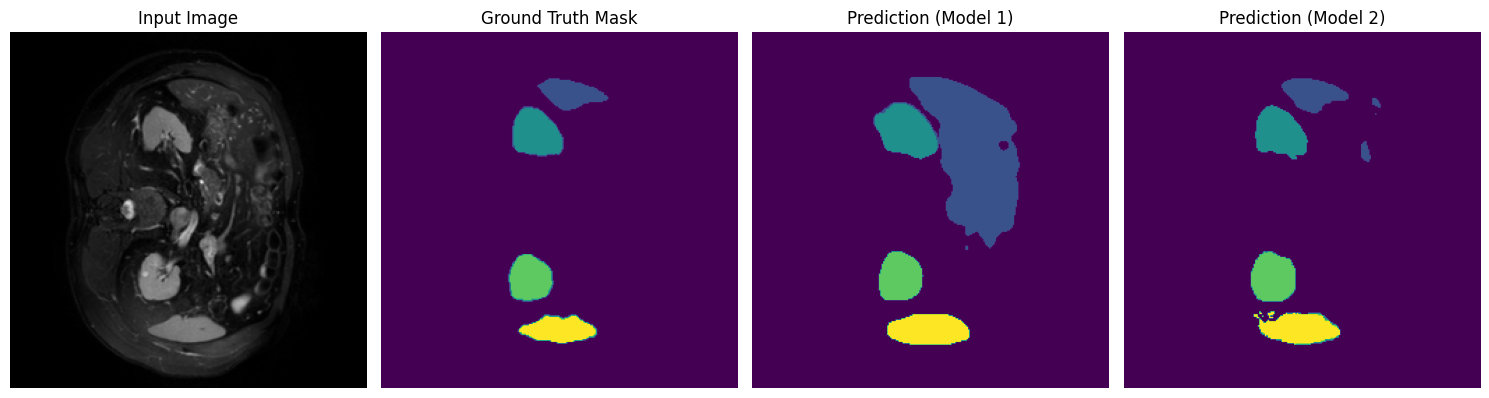

In [124]:
display_comparison([model2,model], test_loader, device, class_names=None)

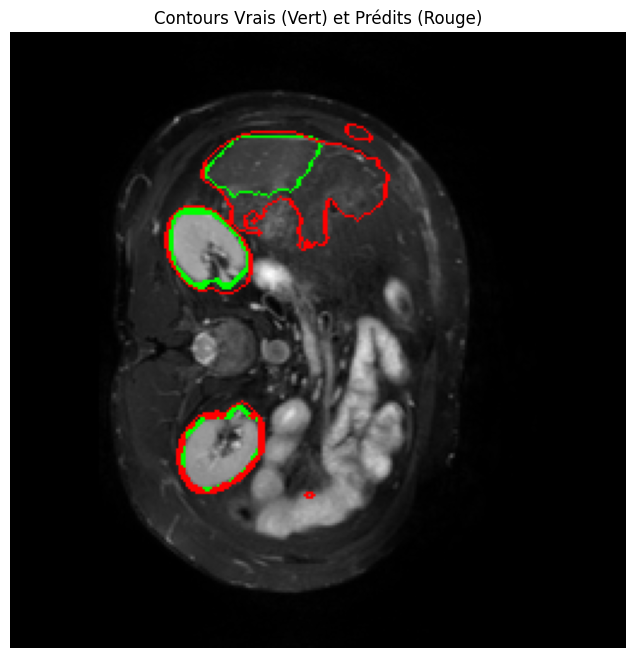

In [171]:
display_random_prediction(model, test_loader, device)

In [ ]:
def evaluation(model, val_loader, criterion, device, num_classes=5):
    val_loss = 0.0
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    model.eval()  # Mettre le modèle en mode évaluation
    for data, label in val_loader:
        data = data.to(device, dtype=torch.float32)
        label = label.to(device, dtype=torch.long).squeeze(1)  # Suppression de la dimension de canal si nécessaire

        with torch.no_grad():
            output = model(data)

        # Calcul de la perte
        loss = criterion(output, label)
        val_loss += loss.item() * data.size(0)

        # Prédictions par pixel
        _, preds = torch.max(output, dim=1)

        # Calcul des pixels corrects pour chaque classe
        for i in range(num_classes):
            class_mask = (label == i)
            class_correct[i] += torch.sum((preds == i) & class_mask).item()
            class_total[i] += torch.sum(class_mask).item()

    # Calcul de la perte moyenne
    val_loss /= len(val_loader.dataset)

    # Affichage des précisions par classe
    print('Validation Loss: {:.6f}'.format(val_loss))
    for i in range(num_classes):
        if class_total[i] > 0:
            accuracy_class = 100.0 * class_correct[i] / class_total[i]
            print(f'Accuracy for class {i}: {accuracy_class:.2f}% ({class_correct[i]}/{class_total[i]})')
        else:
            print(f'Accuracy for class {i}: N/A (no pixels)')

    # Calcul de la précision globale
    total_correct_pixels = sum(class_correct)
    total_pixels = sum(class_total)
    overall_accuracy = 100.0 * total_correct_pixels / total_pixels

    print('Overall pixel-wise accuracy: {:.2f}% ({}/{})'.format(overall_accuracy, total_correct_pixels, total_pixels))

    return val_loss, overall_accuracy, class_correct, class_total


In [24]:
import torch
import random
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

def display_random_prediction_two_models(model1, model2, val_loader, device):
    """
    Affiche une prédiction aléatoire comparant deux modèles sur un batch de validation.
    Args:
        model1: Premier modèle PyTorch.
        model2: Deuxième modèle PyTorch.
        val_loader: DataLoader contenant les données de validation.
        device: Périphérique ('cuda' ou 'cpu').
    """
    # Mettre les modèles en mode évaluation
    model1.eval()
    model2.eval()

    # Sélectionner un batch aléatoire du valid loader
    data_iter = iter(val_loader)
    random_index = random.randint(0, len(val_loader) - 1)

    for _ in range(random_index):
        next(data_iter)  # Ignorer jusqu'à l'index aléatoire

    # Récupérer un batch de données
    data, mask = next(data_iter)
    data = data.to(device, dtype=torch.float32)
    mask = mask.squeeze(1).to(device, dtype=torch.long)

    # Faire des prédictions pour les deux modèles
    with torch.no_grad():
        prediction1 = model1(data)
        predicted_classes1 = torch.argmax(prediction1, dim=1)

        prediction2 = model2(data)
        predicted_classes2 = torch.argmax(prediction2, dim=1)

    # Choisir une image aléatoire dans le batch
    random_image_index = random.randint(0, data.size(0) - 1)
    data_image = data[random_image_index].cpu().squeeze(0).numpy()
    mask_image = mask[random_image_index].cpu().numpy()
    predicted_image1 = predicted_classes1[random_image_index].cpu().numpy()
    predicted_image2 = predicted_classes2[random_image_index].cpu().numpy()

    # Normalisation de l'image source pour affichage
    data_image = (data_image - data_image.min()) / (data_image.max() - data_image.min())

    # Ajouter les contours à l'image source
    image_with_contours = mark_boundaries(data_image, mask_image, color=(0, 1, 0))  # Contours verts (vérité terrain)
    image_with_contours = mark_boundaries(image_with_contours, predicted_image1, color=(0, 0, 1))  # Contours bleus (modèle 1)
    image_with_contours = mark_boundaries(image_with_contours, predicted_image2, color=(1, 0, 0))  # Contours rouges (modèle 2)

    # Afficher l'image avec les contours
    plt.figure(figsize=(8, 8))
    plt.imshow(image_with_contours)
    plt.title('True Mask (Vert),  Classic Unet (Bleu), Augmented Unet (Rouge)')
    plt.axis('off')
    plt.show()


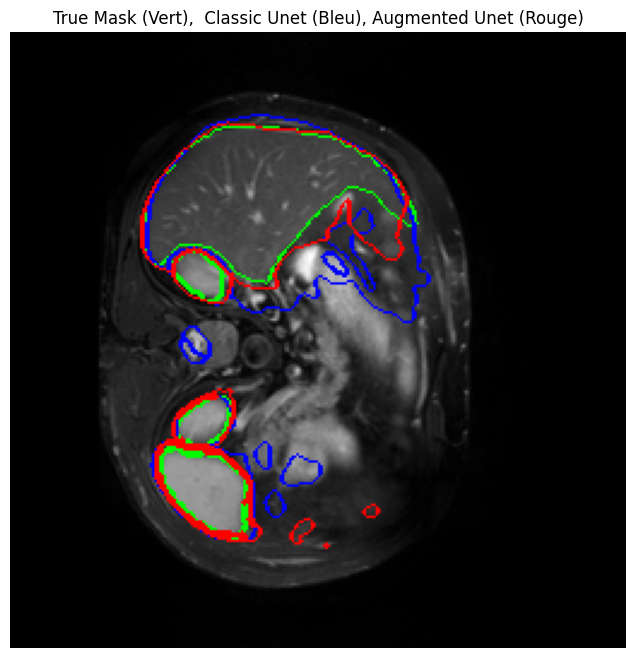

In [25]:
display_random_prediction_two_models(model2,model,test_loader,device)

In [175]:
import torch
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import random
import numpy as np

def display_prediction_for_class(model, val_loader, device, target_class):
    """
    Displays a prediction for a specific class, highlighting true and predicted contours,
    and shows the full mask for the target class.
    
    Args:
        model: Trained segmentation model.
        val_loader: DataLoader for the validation set.
        device: Device to use (CPU or CUDA).
        target_class: Index of the target class to display (e.g., 1 for liver).
    """
    # Set the model to evaluation mode
    model.eval()

    # Iterate through the validation DataLoader to find a batch with the target class
    for data, mask in val_loader:
        data = data.to(device, dtype=torch.float32)
        mask = mask.squeeze(1).to(device, dtype=torch.long)

        # Check if any mask contains the target class
        contains_target_class = (mask == target_class).any(dim=(1, 2))  # Boolean array per image in batch
        if contains_target_class.any():  # If at least one image contains the target class
            break
    else:
        print(f"No images with class {target_class} were found in the validation set.")
        return

    # Select a random image that contains the target class
    indices_with_target_class = torch.where(contains_target_class)[0]
    random_image_index = random.choice(indices_with_target_class)  # Randomly select one
    data_image = data[random_image_index].cpu().squeeze(0).numpy()
    mask_image = mask[random_image_index].cpu().numpy()

    # Make predictions
    with torch.no_grad():
        prediction = model(data)
        predicted_classes = torch.argmax(prediction, dim=1)
        predicted_image = predicted_classes[random_image_index].cpu().numpy()

    # Normalize the input image for visualization
    data_image = (data_image - data_image.min()) / (data_image.max() - data_image.min())

    # Create a smoothed mask for contours to avoid dotted lines (more continuous boundaries)
    smoothed_mask = np.pad(mask_image == target_class, pad_width=1, mode='constant', constant_values=False)
    smoothed_mask = smoothed_mask[1:-1, 1:-1]  # Remove padding for final mask

    smoothed_pred = np.pad(predicted_image == target_class, pad_width=1, mode='constant', constant_values=False)
    smoothed_pred = smoothed_pred[1:-1, 1:-1]  # Remove padding for final predicted mask

    # Add contours for the target class (Ground truth and Prediction)
    image_with_contours = mark_boundaries(data_image, smoothed_mask, color=(0, 1, 0), mode='thick')  # Green for ground truth
    image_with_contours = mark_boundaries(image_with_contours, smoothed_pred, color=(1, 0, 0), mode='thick')  # Red for predictions

    # Create a full mask for the target class
    full_mask = mask_image == target_class
    full_pred_mask = predicted_image == target_class

    # Display the images
    plt.figure(figsize=(12, 12))

    # Plot the original image with contours
    plt.subplot(2, 2, 1)
    plt.imshow(image_with_contours)
    plt.title(f'Class {target_class}: True contours (green) and Predicted contours (red)')
    plt.axis('off')

    # Plot the full ground truth mask for the target class
    plt.subplot(2, 2, 2)
    plt.imshow(full_mask, cmap='gray')
    plt.title(f'Ground Truth Mask for Class {target_class}')
    plt.axis('off')

    # Plot the full predicted mask for the target class
    plt.subplot(2, 2, 3)
    plt.imshow(full_pred_mask, cmap='gray')
    plt.title(f'Predicted Mask for Class {target_class}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


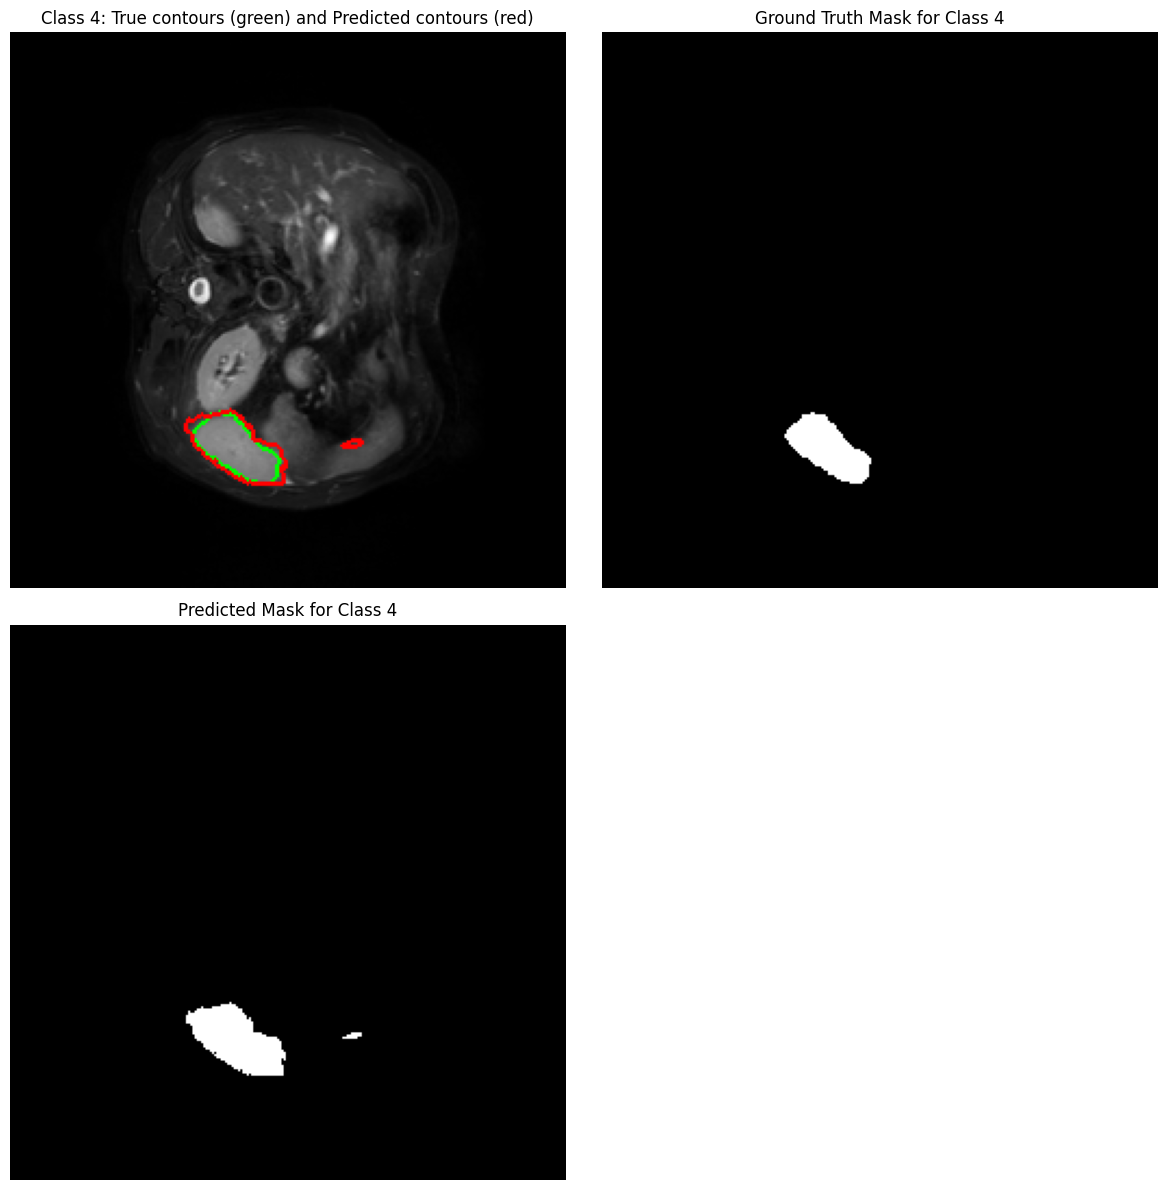

In [189]:
display_prediction_for_class(model,test_loader,device,4)

In [169]:
import torch
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import numpy as np
import random

def visualize_attention_with_outlines_and_scales(model, data_loader, device):
    """
    Affiche les cartes d'attention superposées à l'image source avec les organes détourés,
    et inclut une barre d'échelle pour chaque carte d'attention. Les images sont alignées horizontalement.
    La première image affiche aussi la prédiction du modèle en contours bleus.
    Args:
        model: Le modèle PyTorch générant les cartes d'attention.
        data_loader: DataLoader contenant les données (images et masques de labels).
        device: Périphérique ('cuda' ou 'cpu').
    """
    # Mettre le modèle en mode évaluation
    model.eval()

    # Récupérer un batch de données du DataLoader
    data_iter = iter(data_loader)
    random_index = random.randint(0, len(data_loader) - 1)
    for _ in range(random_index):
        next(data_iter)  # Ignorer jusqu'à l'index aléatoire

    input_tensor, labels = next(data_iter)
    input_tensor = input_tensor.to(device, dtype=torch.float32)
    labels = labels.squeeze(1).to(device, dtype=torch.long)  # Assurez-vous que les labels sont au bon format

    # Passage des données dans le modèle pour générer les cartes d'attention
    with torch.no_grad():
        output, attention_maps = model(input_tensor, return_attention=True)
        predicted_classes = torch.argmax(output, dim=1)

    # Affichage pour la première image du batch (index 0)
    image_index = 0
    original_image = input_tensor[image_index].cpu().squeeze(0).numpy()
    label_image = labels[image_index].cpu().numpy()
    predicted_image = predicted_classes[image_index].cpu().numpy()

    # Ajouter les contours des labels et des prédictions
    image_with_labels = mark_boundaries(original_image, label_image, color=(1, 1, 0))  # Contours jaunes
    image_with_predictions = mark_boundaries(image_with_labels, predicted_image, color=(0, 0, 1))  # Contours bleus

    # Créer une figure pour aligner les images horizontalement
    num_attention_maps = len(attention_maps)
    fig, axes = plt.subplots(1, num_attention_maps + 1, figsize=(20, 5))

    # Afficher l'image originale avec les labels et la prédiction
    axes[0].imshow(image_with_predictions, cmap='gray')
    axes[0].set_title('Image, Labels (Yellow) and Prediction (Blue)')
    axes[0].axis('off')

    # Afficher les cartes d'attention
    for i, attention_map in enumerate(attention_maps):
        # Normaliser la carte d'attention
        att_map = attention_map[image_index].squeeze(0).cpu().numpy()
        att_map = (att_map - att_map.min()) / (att_map.max() - att_map.min())

        # Ajouter l'image originale et la carte d'attention
        im = axes[i + 1].imshow(att_map, cmap='jet')  # Superposition de la carte d'attention

        # Ajouter une barre d'échelle (légende)
        cbar = plt.colorbar(im, ax=axes[i + 1], fraction=0.046, pad=0.04)
        cbar.set_label('Visualisation of the Attention', rotation=270, labelpad=15)

        axes[i + 1].set_title(f'Attention Map {i + 1}')
        axes[i + 1].axis('off')

    # Réglage de la mise en page
    plt.subplots_adjust(wspace=0.2)  # Réduction de l'espace entre les images
    plt.tight_layout()
    plt.show()


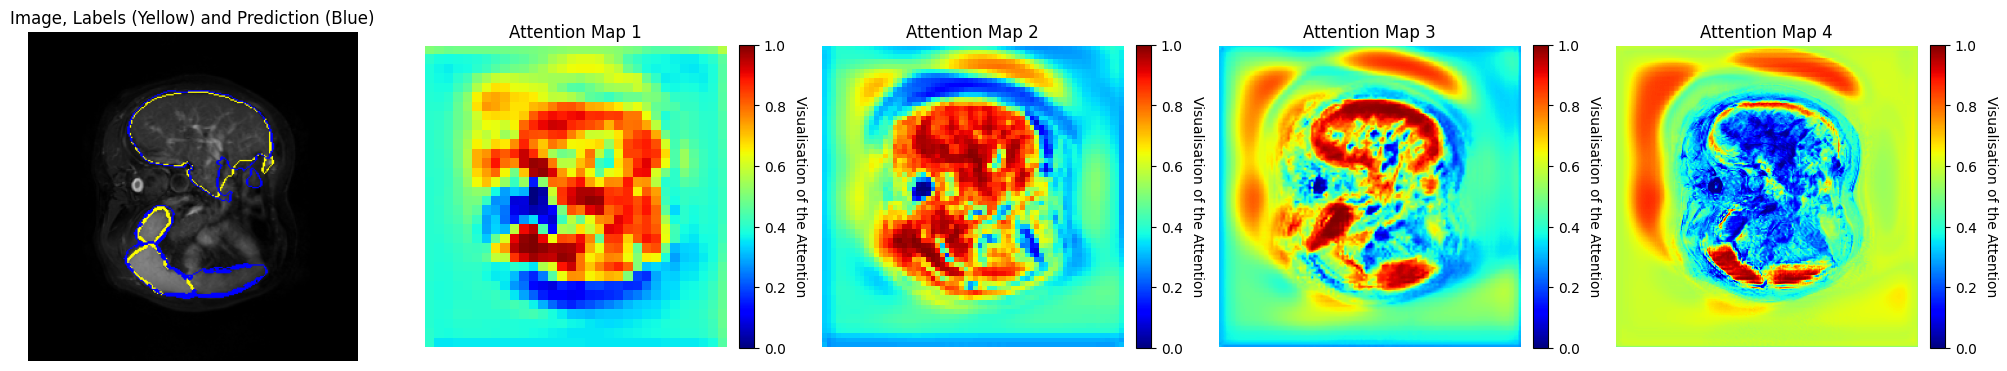

In [170]:
visualize_attention_with_outlines_and_scales(model, test_loader, device)